In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6871946977877715155, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12005190222062089101
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11713313863965317364
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15882446439
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5413790482328475451
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2, l1
from sklearn.metrics import cohen_kappa_score, accuracy_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.14.0


In [5]:
batch_size = 64
img_height, img_width = 600, 450
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
print(os.listdir("../input/digestpath-classification/digestpath_classification/digestpath_classification"))

['train', 'test']


In [7]:
train_dir = '../input/digestpath-classification/digestpath_classification/digestpath_classification/train/'
test_dir = '../input/digestpath-classification/digestpath_classification/digestpath_classification/test/'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 460 images belonging to 2 classes.
Found 115 images belonging to 2 classes.
Found 85 images belonging to 2 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 460
nb_validation_samples: 115
nb_test_samples: 85

predict_size_train: 8
predict_size_validation: 2
predict_size_test: 2

 num_classes: 2


In [11]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "MobileNet_descriptors"

In [12]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [13]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge, NASNetMobile
from keras.applications import MobileNet

In [14]:
base_model1=InceptionResNetV2(weights=inception_resnet_v2_weights, include_top=False, pooling = "avg")

In [15]:
bottleneck_final_model = base_model1

In [16]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [17]:
# c1 = model.layers[11].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[18].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[28].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[51].output
# c4 = GlobalAveragePooling2D()(c4) 

# c5 = model.layers[74].output
# c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[101].output
# c6 = GlobalAveragePooling2D()(c6) 

# c7 = model.layers[120].output
# c7 = GlobalAveragePooling2D()(c7) 

# c8 = model.layers[152].output
# c8 = GlobalAveragePooling2D()(c8) 

# c9 = model.layers[184].output
# c9 = GlobalAveragePooling2D()(c9) 

# c10 = model.layers[216].output
# c10 = GlobalAveragePooling2D()(c10) 

# c11 = model.layers[248].output
# c11 = GlobalAveragePooling2D()(c11) 

# c12 = model.layers[263].output
# c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[294].output
# c13 = GlobalAveragePooling2D()(c13) 

# con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [18]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [19]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [20]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [21]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [22]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [43]:
adam_opt=Adam(lr=0.0001, beta_1=0.7, beta_2=0.5)

model = Sequential()
model.add(Dense(2048, activation="tanh", kernel_regularizer=l2(0.01), bias_regularizer=l2(1e-06), activity_regularizer=l1(1e-05)))
# model.add(Dropout(0.5))

model.add(Dense(128, activation="tanh", kernel_regularizer=l2(0.01), bias_regularizer=l2(1e-06), activity_regularizer=l1(1e-05)))
# model.add(Dropout(0.5))

# model.add(Dense(512, activation="relu", kernel_regularizer=l2(1e-06), bias_regularizer=l2(0.01), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

Train on 460 samples, validate on 115 samples
Epoch 1/1000
 - 4s - loss: 20.6041 - acc: 0.7109 - val_loss: 20.1297 - val_acc: 0.7913
Epoch 2/1000
 - 0s - loss: 19.9161 - acc: 0.7957 - val_loss: 19.5037 - val_acc: 0.8000
Epoch 3/1000
 - 0s - loss: 19.2005 - acc: 0.8457 - val_loss: 18.7726 - val_acc: 0.8522
Epoch 4/1000
 - 0s - loss: 18.4287 - acc: 0.8674 - val_loss: 18.0999 - val_acc: 0.8087
Epoch 5/1000
 - 0s - loss: 17.7558 - acc: 0.8652 - val_loss: 17.5437 - val_acc: 0.8000
Epoch 6/1000
 - 0s - loss: 17.1464 - acc: 0.8500 - val_loss: 16.7976 - val_acc: 0.8435
Epoch 7/1000
 - 0s - loss: 16.5289 - acc: 0.8870 - val_loss: 16.1916 - val_acc: 0.8348
Epoch 8/1000
 - 0s - loss: 15.9036 - acc: 0.8761 - val_loss: 15.6148 - val_acc: 0.8348
Epoch 9/1000
 - 0s - loss: 15.3985 - acc: 0.8783 - val_loss: 15.2342 - val_acc: 0.8174
Epoch 10/1000
 - 0s - loss: 14.9097 - acc: 0.8826 - val_loss: 14.7728 - val_acc: 0.8087
Epoch 11/1000
 - 0s - loss: 14.3405 - acc: 0.8935 - val_loss: 14.1029 - val_acc: 0.

Epoch 96/1000
 - 0s - loss: 1.0659 - acc: 0.9826 - val_loss: 1.3368 - val_acc: 0.8522
Epoch 97/1000
 - 0s - loss: 1.0424 - acc: 0.9783 - val_loss: 1.3121 - val_acc: 0.8522
Epoch 98/1000
 - 0s - loss: 1.0355 - acc: 0.9739 - val_loss: 1.2972 - val_acc: 0.8522
Epoch 99/1000
 - 0s - loss: 1.0048 - acc: 0.9848 - val_loss: 1.5284 - val_acc: 0.7826
Epoch 100/1000
 - 0s - loss: 1.0109 - acc: 0.9652 - val_loss: 1.2854 - val_acc: 0.8348
Epoch 101/1000
 - 0s - loss: 0.9713 - acc: 0.9804 - val_loss: 1.2479 - val_acc: 0.8870
Epoch 102/1000
 - 0s - loss: 0.9666 - acc: 0.9739 - val_loss: 1.2395 - val_acc: 0.8522
Epoch 103/1000
 - 0s - loss: 0.9488 - acc: 0.9804 - val_loss: 1.2282 - val_acc: 0.8522
Epoch 104/1000
 - 0s - loss: 0.9240 - acc: 0.9848 - val_loss: 1.1972 - val_acc: 0.8783
Epoch 105/1000
 - 0s - loss: 0.9328 - acc: 0.9652 - val_loss: 1.2053 - val_acc: 0.8435
Epoch 106/1000
 - 0s - loss: 0.8990 - acc: 0.9804 - val_loss: 1.2016 - val_acc: 0.8348
Epoch 107/1000
 - 0s - loss: 0.8866 - acc: 0.98

Epoch 191/1000
 - 0s - loss: 0.3727 - acc: 0.9891 - val_loss: 0.8469 - val_acc: 0.8174
Epoch 192/1000
 - 0s - loss: 0.3596 - acc: 0.9935 - val_loss: 0.6995 - val_acc: 0.8783
Epoch 193/1000
 - 0s - loss: 0.3754 - acc: 0.9804 - val_loss: 0.8544 - val_acc: 0.8261
Epoch 194/1000
 - 0s - loss: 0.3598 - acc: 0.9935 - val_loss: 0.7228 - val_acc: 0.8609
Epoch 195/1000
 - 0s - loss: 0.3601 - acc: 0.9913 - val_loss: 0.7641 - val_acc: 0.8435
Epoch 196/1000
 - 0s - loss: 0.3493 - acc: 0.9957 - val_loss: 0.7691 - val_acc: 0.8435
Epoch 197/1000
 - 0s - loss: 0.3412 - acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.8609
Epoch 198/1000
 - 0s - loss: 0.3610 - acc: 0.9804 - val_loss: 0.7147 - val_acc: 0.8609
Epoch 199/1000
 - 0s - loss: 0.3377 - acc: 0.9957 - val_loss: 0.6971 - val_acc: 0.8522
Epoch 200/1000
 - 0s - loss: 0.3283 - acc: 0.9935 - val_loss: 0.6963 - val_acc: 0.8696
Epoch 201/1000
 - 0s - loss: 0.3484 - acc: 0.9891 - val_loss: 0.9773 - val_acc: 0.7826
Epoch 202/1000
 - 0s - loss: 0.3635 - acc: 

 - 0s - loss: 0.1963 - acc: 0.9978 - val_loss: 1.0009 - val_acc: 0.7652
Epoch 286/1000
 - 0s - loss: 0.2619 - acc: 0.9739 - val_loss: 0.5941 - val_acc: 0.8696
Epoch 287/1000
 - 0s - loss: 0.1995 - acc: 1.0000 - val_loss: 0.6336 - val_acc: 0.8609
Epoch 288/1000
 - 0s - loss: 0.1984 - acc: 0.9978 - val_loss: 0.6681 - val_acc: 0.8435
Epoch 289/1000
 - 0s - loss: 0.1969 - acc: 0.9978 - val_loss: 0.6114 - val_acc: 0.8522
Epoch 290/1000
 - 0s - loss: 0.1968 - acc: 0.9978 - val_loss: 0.5955 - val_acc: 0.8522
Epoch 291/1000
 - 0s - loss: 0.1914 - acc: 0.9978 - val_loss: 0.5998 - val_acc: 0.8609
Epoch 292/1000
 - 0s - loss: 0.2014 - acc: 0.9935 - val_loss: 0.7125 - val_acc: 0.8261
Epoch 293/1000
 - 0s - loss: 0.1965 - acc: 0.9978 - val_loss: 0.5843 - val_acc: 0.8696
Epoch 294/1000
 - 0s - loss: 0.1922 - acc: 1.0000 - val_loss: 0.6155 - val_acc: 0.8522
Epoch 295/1000
 - 0s - loss: 0.1922 - acc: 0.9978 - val_loss: 0.7514 - val_acc: 0.8261
Epoch 296/1000
 - 0s - loss: 0.2007 - acc: 0.9957 - val_lo

Epoch 380/1000
 - 0s - loss: 0.1346 - acc: 1.0000 - val_loss: 0.5568 - val_acc: 0.8783
Epoch 381/1000
 - 0s - loss: 0.1392 - acc: 1.0000 - val_loss: 0.5914 - val_acc: 0.8522
Epoch 382/1000
 - 0s - loss: 0.1325 - acc: 1.0000 - val_loss: 0.5990 - val_acc: 0.8522
Epoch 383/1000
 - 0s - loss: 0.1323 - acc: 1.0000 - val_loss: 0.6526 - val_acc: 0.8435
Epoch 384/1000
 - 0s - loss: 0.1407 - acc: 0.9957 - val_loss: 0.5722 - val_acc: 0.8609
Epoch 385/1000
 - 0s - loss: 0.1402 - acc: 1.0000 - val_loss: 0.5577 - val_acc: 0.8783
Epoch 386/1000
 - 0s - loss: 0.1338 - acc: 0.9978 - val_loss: 0.5957 - val_acc: 0.8609
Epoch 387/1000
 - 0s - loss: 0.1329 - acc: 1.0000 - val_loss: 0.5728 - val_acc: 0.8609
Epoch 388/1000
 - 0s - loss: 0.1304 - acc: 1.0000 - val_loss: 0.6065 - val_acc: 0.8522
Epoch 389/1000
 - 0s - loss: 0.1340 - acc: 1.0000 - val_loss: 0.8119 - val_acc: 0.8087
Epoch 390/1000
 - 0s - loss: 0.1418 - acc: 0.9978 - val_loss: 0.6837 - val_acc: 0.8435
Epoch 391/1000
 - 0s - loss: 0.1450 - acc: 

 - 0s - loss: 0.1087 - acc: 1.0000 - val_loss: 0.5480 - val_acc: 0.8783
Epoch 475/1000
 - 0s - loss: 0.1127 - acc: 0.9978 - val_loss: 0.5348 - val_acc: 0.8609
Epoch 476/1000
 - 0s - loss: 0.1030 - acc: 1.0000 - val_loss: 0.5271 - val_acc: 0.8609
Epoch 477/1000
 - 0s - loss: 0.0999 - acc: 1.0000 - val_loss: 0.5839 - val_acc: 0.8609
Epoch 478/1000
 - 0s - loss: 0.1038 - acc: 1.0000 - val_loss: 0.5244 - val_acc: 0.8522
Epoch 479/1000
 - 0s - loss: 0.1032 - acc: 1.0000 - val_loss: 0.5358 - val_acc: 0.8522
Epoch 480/1000
 - 0s - loss: 0.1004 - acc: 1.0000 - val_loss: 0.5433 - val_acc: 0.8522
Epoch 481/1000
 - 0s - loss: 0.0997 - acc: 1.0000 - val_loss: 0.5351 - val_acc: 0.8522
Epoch 482/1000
 - 0s - loss: 0.1030 - acc: 1.0000 - val_loss: 0.5806 - val_acc: 0.8609
Epoch 483/1000
 - 0s - loss: 0.1036 - acc: 1.0000 - val_loss: 0.5952 - val_acc: 0.8000
Epoch 484/1000
 - 0s - loss: 0.1217 - acc: 0.9978 - val_loss: 0.7906 - val_acc: 0.8000
Epoch 485/1000
 - 0s - loss: 0.1146 - acc: 0.9978 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0871 - acc: 1.0000 - val_loss: 0.5451 - val_acc: 0.8522
Epoch 570/1000
 - 0s - loss: 0.0828 - acc: 1.0000 - val_loss: 0.5404 - val_acc: 0.8696
Epoch 571/1000
 - 0s - loss: 0.0876 - acc: 1.0000 - val_loss: 0.5599 - val_acc: 0.8609
Epoch 572/1000
 - 0s - loss: 0.0833 - acc: 1.0000 - val_loss: 0.5292 - val_acc: 0.8609
Epoch 573/1000
 - 0s - loss: 0.0853 - acc: 1.0000 - val_loss: 0.6253 - val_acc: 0.8522
Epoch 574/1000
 - 0s - loss: 0.0885 - acc: 1.0000 - val_loss: 0.6311 - val_acc: 0.8522
Epoch 575/1000
 - 0s - loss: 0.0846 - acc: 1.0000 - val_loss: 0.6026 - val_acc: 0.8522
Epoch 576/1000
 - 0s - loss: 0.0893 - acc: 1.0000 - val_loss: 0.5439 - val_acc: 0.8609
Epoch 577/1000
 - 0s - loss: 0.0861 - acc: 1.0000 - val_loss: 0.5373 - val_acc: 0.8609
Epoch 578/1000
 - 0s - loss: 0.0822 - acc: 1.0000 - val_loss: 0.7581 - val_acc: 0.8087
Epoch 579/1000
 - 0s - loss: 0.0894 - acc: 1.0000 - val_loss: 0.5404 - val_acc: 0.8609
Epoch 580/1000
 - 0s - loss: 0.0982 - acc: 

 - 0s - loss: 0.0786 - acc: 1.0000 - val_loss: 0.5418 - val_acc: 0.8522
Epoch 664/1000
 - 0s - loss: 0.0769 - acc: 1.0000 - val_loss: 0.5843 - val_acc: 0.8522
Epoch 665/1000
 - 0s - loss: 0.0738 - acc: 1.0000 - val_loss: 0.5935 - val_acc: 0.8522
Epoch 666/1000
 - 0s - loss: 0.0777 - acc: 1.0000 - val_loss: 0.6011 - val_acc: 0.8609
Epoch 667/1000
 - 0s - loss: 0.0735 - acc: 1.0000 - val_loss: 0.5481 - val_acc: 0.8522
Epoch 668/1000
 - 0s - loss: 0.0772 - acc: 1.0000 - val_loss: 0.5415 - val_acc: 0.8696
Epoch 669/1000
 - 0s - loss: 0.0748 - acc: 1.0000 - val_loss: 0.5583 - val_acc: 0.8609
Epoch 670/1000
 - 0s - loss: 0.0785 - acc: 0.9978 - val_loss: 0.5466 - val_acc: 0.8609
Epoch 671/1000
 - 0s - loss: 0.0785 - acc: 1.0000 - val_loss: 0.9832 - val_acc: 0.7826
Epoch 672/1000
 - 0s - loss: 0.0926 - acc: 1.0000 - val_loss: 0.5875 - val_acc: 0.8609
Epoch 673/1000
 - 0s - loss: 0.0777 - acc: 1.0000 - val_loss: 0.5660 - val_acc: 0.8522
Epoch 674/1000
 - 0s - loss: 0.0732 - acc: 1.0000 - val_lo

Epoch 758/1000
 - 0s - loss: 0.0758 - acc: 1.0000 - val_loss: 0.5537 - val_acc: 0.8609
Epoch 759/1000
 - 0s - loss: 0.0661 - acc: 1.0000 - val_loss: 0.5845 - val_acc: 0.8522
Epoch 760/1000
 - 0s - loss: 0.0637 - acc: 1.0000 - val_loss: 0.5553 - val_acc: 0.8435
Epoch 761/1000
 - 0s - loss: 0.0639 - acc: 1.0000 - val_loss: 0.5835 - val_acc: 0.8609
Epoch 762/1000
 - 0s - loss: 0.0703 - acc: 1.0000 - val_loss: 0.5880 - val_acc: 0.8348
Epoch 763/1000
 - 0s - loss: 0.0632 - acc: 1.0000 - val_loss: 0.5532 - val_acc: 0.8522
Epoch 764/1000
 - 0s - loss: 0.0693 - acc: 1.0000 - val_loss: 0.5478 - val_acc: 0.8609
Epoch 765/1000
 - 0s - loss: 0.0642 - acc: 1.0000 - val_loss: 0.6104 - val_acc: 0.8348
Epoch 766/1000
 - 0s - loss: 0.0845 - acc: 0.9957 - val_loss: 0.6097 - val_acc: 0.8522
Epoch 767/1000
 - 0s - loss: 0.0688 - acc: 1.0000 - val_loss: 0.5640 - val_acc: 0.8435
Epoch 768/1000
 - 0s - loss: 0.0641 - acc: 1.0000 - val_loss: 0.7320 - val_acc: 0.8435
Epoch 769/1000
 - 0s - loss: 0.0679 - acc: 

 - 0s - loss: 0.0612 - acc: 1.0000 - val_loss: 0.5572 - val_acc: 0.8435
Epoch 853/1000
 - 0s - loss: 0.0603 - acc: 1.0000 - val_loss: 0.6664 - val_acc: 0.8435
Epoch 854/1000
 - 0s - loss: 0.0580 - acc: 1.0000 - val_loss: 0.9425 - val_acc: 0.8000
Epoch 855/1000
 - 0s - loss: 0.1066 - acc: 0.9804 - val_loss: 0.5672 - val_acc: 0.8870
Epoch 856/1000
 - 0s - loss: 0.0702 - acc: 1.0000 - val_loss: 0.8186 - val_acc: 0.8261
Epoch 857/1000
 - 0s - loss: 0.0750 - acc: 0.9978 - val_loss: 0.5750 - val_acc: 0.8609
Epoch 858/1000
 - 0s - loss: 0.0626 - acc: 1.0000 - val_loss: 0.6688 - val_acc: 0.8435
Epoch 859/1000
 - 0s - loss: 0.0605 - acc: 1.0000 - val_loss: 0.5957 - val_acc: 0.8522
Epoch 860/1000
 - 0s - loss: 0.0592 - acc: 1.0000 - val_loss: 0.5485 - val_acc: 0.8609
Epoch 861/1000
 - 0s - loss: 0.0586 - acc: 1.0000 - val_loss: 0.6072 - val_acc: 0.8609
Epoch 862/1000
 - 0s - loss: 0.0602 - acc: 1.0000 - val_loss: 0.6087 - val_acc: 0.8522
Epoch 863/1000
 - 0s - loss: 0.0617 - acc: 1.0000 - val_lo

Epoch 947/1000
 - 0s - loss: 0.0589 - acc: 1.0000 - val_loss: 0.7518 - val_acc: 0.8435
Epoch 948/1000
 - 0s - loss: 0.0697 - acc: 0.9978 - val_loss: 0.6103 - val_acc: 0.8522
Epoch 949/1000
 - 0s - loss: 0.0544 - acc: 1.0000 - val_loss: 0.6368 - val_acc: 0.8000
Epoch 950/1000
 - 0s - loss: 0.0741 - acc: 1.0000 - val_loss: 0.5921 - val_acc: 0.8522
Epoch 951/1000
 - 0s - loss: 0.0524 - acc: 1.0000 - val_loss: 0.7185 - val_acc: 0.8522
Epoch 952/1000
 - 0s - loss: 0.0608 - acc: 0.9978 - val_loss: 0.5768 - val_acc: 0.8696
Epoch 953/1000
 - 0s - loss: 0.0588 - acc: 1.0000 - val_loss: 0.8425 - val_acc: 0.8000
Epoch 954/1000
 - 0s - loss: 0.0729 - acc: 0.9978 - val_loss: 0.5662 - val_acc: 0.8609
Epoch 955/1000
 - 0s - loss: 0.0564 - acc: 1.0000 - val_loss: 0.5891 - val_acc: 0.8522
Epoch 956/1000
 - 0s - loss: 0.1059 - acc: 0.9804 - val_loss: 0.6264 - val_acc: 0.8261
Epoch 957/1000
 - 0s - loss: 0.0741 - acc: 1.0000 - val_loss: 1.0223 - val_acc: 0.7913
Epoch 958/1000
 - 0s - loss: 0.0770 - acc: 

In [44]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

115/115 [==============================] - 0s 85us/step
Validation Accuracy: 85.2174%
Validation Loss: 0.5688307274942813


In [45]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

from sklearn.metrics import accuracy_score, confusion_matrix
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Test Accuracy: {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Test Accuracy: 0.9411764705882353


Confusion Matrix
[[52  3]
 [ 2 28]]


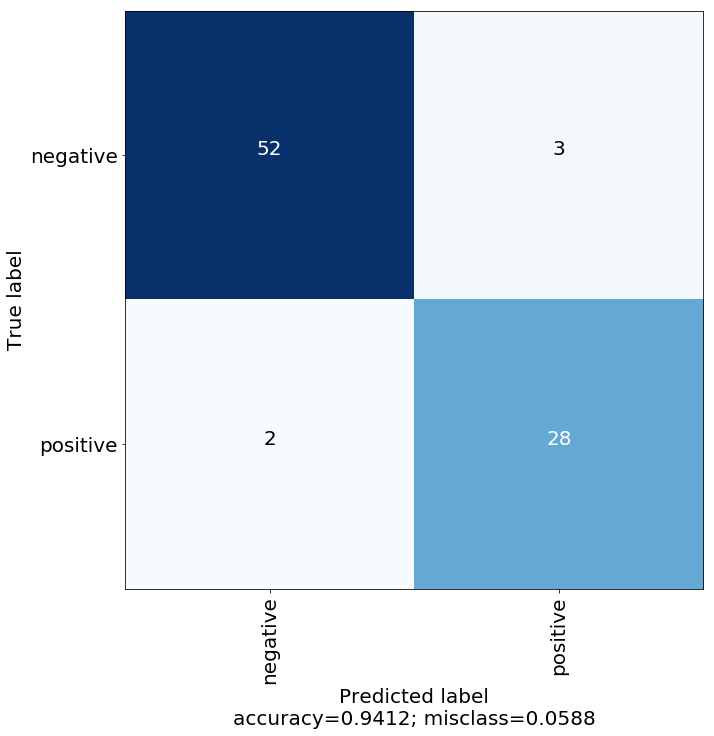

In [46]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[52  3]
 [ 2 28]]
              precision    recall  f1-score   support

    negative       0.96      0.95      0.95        55
    positive       0.90      0.93      0.92        30

    accuracy                           0.94        85
   macro avg       0.93      0.94      0.94        85
weighted avg       0.94      0.94      0.94        85



In [54]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9629629629629629
Specificity :  0.9032258064516129


In [55]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

85/85 [==============================] - 0s 631us/step
Precision =  0.9418792606648394
Recall =  0.9411764705882353
f1_score =  0.9413887979616573


In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9393939393939394


In [57]:
# model.save('extracted_features/xception_modified_model.h5')
# model.save_weights('extracted_features/xception_modified_weights.h5')

# Machine Learning Algorithms

In [58]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score, classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score


k_fold = KFold(n_splits=5, shuffle=True, random_state=5)

In [59]:
y_test = np.asarray(test_labels)
y_test = np.argmax(y_test, axis=1)

y_train = np.asarray(train_labels)
y_train = np.argmax(y_train, axis=1)

## Bagging Classifier

In [60]:
clf = BaggingClassifier(RandomForestClassifier(), n_estimators = 300 )
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('Bagging Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 0.9869565217391304
Test accuracy 0.8588235294117647
Bagging Classifier test accuracies 0.8588
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        55
           1       0.88      0.70      0.78        30

    accuracy                           0.86        85
   macro avg       0.86      0.82      0.84        85
weighted avg       0.86      0.86      0.85        85

0.8588235294117647


In [61]:
clf = BaggingClassifier(RandomForestClassifier(), n_estimators = 300 )
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("BaggingClassifier - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 76.3889 and (STDEV 0.1328)
Best result for fold 6
Best accuracy is 1.0
Scores of all folds: [0.88888889 0.88888889 0.66666667 0.77777778 0.66666667 0.625
 1.         0.625      0.625      0.875     ]
BaggingClassifier - Test Accuracy on all folds: 0.76 (+/- 0.27)


## AdaBoost Classifier

In [62]:
clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators = 300 )
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 1.0
Test accuracy 0.8
AdaBoost Classifier test accuracies 0.8000
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        55
           1       0.81      0.57      0.67        30

    accuracy                           0.80        85
   macro avg       0.80      0.75      0.76        85
weighted avg       0.80      0.80      0.79        85

0.8


In [63]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(AdaBoost Classifier) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 78.8889 and (STDEV 0.1556)
Best result for fold 1
Best accuracy is 1.0
Scores of all folds: [0.77777778 1.         0.66666667 1.         0.44444444 0.75
 0.75       0.875      0.875      0.75      ]
(AdaBoost Classifier) Test Accuracy on all folds: 0.79 (+/- 0.31)


## XGBoost Classifier

In [64]:
clf = xgb.XGBClassifier()
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('XGB Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 1.0
Test accuracy 0.8705882352941177
XGB Classifier test accuracies 0.8706
              precision    recall  f1-score   support

           0       0.85      0.96      0.91        55
           1       0.91      0.70      0.79        30

    accuracy                           0.87        85
   macro avg       0.88      0.83      0.85        85
weighted avg       0.88      0.87      0.87        85

0.8705882352941177


In [65]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("XGB - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 85.2778 and (STDEV 0.1216)
Best result for fold 5
Best accuracy is 1.0
Scores of all folds: [0.77777778 0.77777778 0.66666667 0.88888889 0.66666667 1.
 1.         1.         0.875      0.875     ]
XGB - Test Accuracy on all folds: 0.85 (+/- 0.24)


## Decision Tree Classifier

In [66]:
clf = DecisionTreeClassifier()
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('DecisionTree Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 1.0
Test accuracy 0.788235294117647
DecisionTree Classifier test accuracies 0.7882
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        55
           1       0.71      0.67      0.69        30

    accuracy                           0.79        85
   macro avg       0.77      0.76      0.76        85
weighted avg       0.79      0.79      0.79        85

0.788235294117647


In [67]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("DecisionTree - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 77.5000 and (STDEV 0.1356)
Best result for fold 1
Best accuracy is 0.8888888888888888
Scores of all folds: [0.77777778 0.88888889 0.88888889 0.88888889 0.55555556 0.5
 0.875      0.875      0.75       0.75      ]
DecisionTree - Test Accuracy on all folds: 0.78 (+/- 0.27)


## Random Forest Classifier

In [68]:
clf = RandomForestClassifier(n_estimators=5)
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('RandomForest Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 0.9804347826086957
Test accuracy 0.8
RandomForest Classifier test accuracies 0.8000
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        55
           1       0.72      0.70      0.71        30

    accuracy                           0.80        85
   macro avg       0.78      0.78      0.78        85
weighted avg       0.80      0.80      0.80        85

0.8


In [69]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, test_labels, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(RandomForest) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 74.3056 and (STDEV 0.1344)
Best result for fold 1
Best accuracy is 0.8888888888888888
Scores of all folds: [0.66666667 0.88888889 0.77777778 0.66666667 0.55555556 0.5
 0.875      0.875      0.75       0.875     ]
(RandomForest) Test Accuracy on all folds: 0.74 (+/- 0.27)


# Light GBM

In [70]:
import lightgbm as lgb

lgbm=lgb.LGBMClassifier(n_estimators=1000, class_weight="balanced", reg_alpha=0.1, reg_lambda=0.1, learning_rate=0.001, num_leaves=400,
                        random_state=523, boosting='dart')

lgbm_scores=cross_val_score(lgbm,train_data, y_train, cv=10)
print(lgbm_scores)
print("Train accuracy mean and std %.2f" %np.mean(lgbm_scores),"+/- %.2f"%np.std(lgbm_scores))

[0.61702128 0.80851064 0.82978723 0.89361702 0.7173913  0.84782609
 0.84444444 0.84444444 0.8        0.88888889]
Train accuracy mean and std 0.81 +/- 0.08


In [71]:
lgbm.fit(train_data, y_train)
y_pred=lgbm.predict(test_data)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        55
           1       0.77      0.77      0.77        30

    accuracy                           0.84        85
   macro avg       0.82      0.82      0.82        85
weighted avg       0.84      0.84      0.84        85

0.8


In [72]:
scoring = 'accuracy'
scores = cross_val_score(lgbm, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(LighGBM) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 76.8056 and (STDEV 0.1284)
Best result for fold 0
Best accuracy is 1.0
Scores of all folds: [1.         0.66666667 0.55555556 0.66666667 0.66666667 0.875
 0.75       0.875      0.875      0.75      ]
(LighGBM) Test Accuracy on all folds: 0.77 (+/- 0.26)


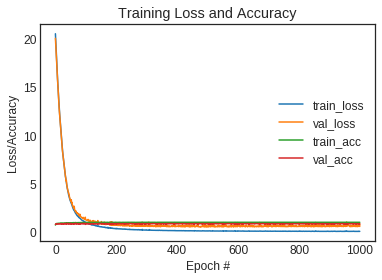

In [73]:
plt.rcParams.update({'font.size': 12})

import seaborn
plt.style.use('seaborn-white')

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend(loc="center right")

In [76]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 3, 5, 10, None], 
    "min_samples_split": [2, 3, 5, 10],
    "min_samples_leaf": [1, 5, 10, 20]
}

tree_model = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5).fit(train_data, y_train)
print(accuracy_score(y_train, tree_model.predict(train_data)))
print(tree_model.best_score_)
# print(accuracy_score(y_val, tree_model.predict(X_val)))
print(tree_model.best_params_)
print(tree_model.best_estimator_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9304347826086956
0.8021739130434783
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
